# Проект: Статистический анализ данных сервиса аренды самокатов GoFast.

## Описание проекта.
**Описание:** Анализ данных мобильного сервиса аренды самокатов GoFast.

**Цель проекта:** Необходимо проанализировать данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти. Найти ключевые отличия между пользователями с подпиской и без, определить, на каких пользователей делать ставку для увелечения прибыли.

**Ход исследования:**

Данные для анализа я получу из файлов: Пользователи — users_go.csv; Поездки — rides_go.csv; Подписки — subscriptions_go.csv. О качестве данных заранее ничего не известно, поэтому перед тем, как приступить к целям исследования понадобиться обзор данных.

Проверю данные на ошибки и оценю их влияние на исследование. На этапе предобраюотки поищу возможность исправить найденные ошибки, которые не преведут к искажению конечного результата. Создам необходимые столбцы и приступлю к исследовательскому анализу.

**Основные задачи, которые необходимо выполнить:**
1. Предобработка.
2. Исследовательский анализ.
3. Объединение данных.
4. Подсчет выручки.
5. Проверка гипотез и формирование выводов:
    1. тратят ли пользователи с подпиской больше времени на поездки?
    2. можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? (расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката).
    3. будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
    4. такая ситуация: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
6. Формирование итогового вывода и написание рекомендаций для бизнеса.    


## Описание данных. 
В распоряжении имеются данные о некоторых пользователях из нескольких городов, а также об их поездках. Данные хранятся в трех датафреймах.

1. *Пользователи — users_go.csv*
- user_id - уникальный идентификатор пользователя,
- name - имя пользователя,
- age - возраст,
- city - город,
- subscription_type - тип подписки (free, ultra).

2. *Поездки — rides_go.csv*
- user_id - уникальный идентификатор пользователя,
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах),
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»,
- date - дата совершения поездки.

3. *Подписки — subscriptions_go.csv*
- subscription_type - тип подписки (free, ultra),
- minute_price - стоимость одной минуты поездки по данной подписке,
- start_ride_price - стоимость начала поездки,
- subscription_fee - стоимость ежемесячного платежа.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. *без подписки - free*
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. *с подпиской Ultra - ultra*
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.


##  Загрузка данных.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.dates as mdates # работа с датами
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as ticker

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from ast import literal_eval
from scipy import stats as st #проверка гипотез

In [2]:
pd.set_option('display.max_columns', None) #команда для отображения всех столбцов датафрейма
pd.set_option('display.max_rows', None) #команда для отображения всех строк датафрейма
pd.set_option('display.float_format', lambda x: '%.3f' % x) #перевод данных из экспоненциальной нотации в обычную

In [3]:
# Загрузка данных
try:
    users_go = pd.read_csv('/datasets/users_go.csv')                 # пользователи
    rides_go = pd.read_csv('/datasets/rides_go.csv')                 # поездки 
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv') # подписки
    display("Файлы успешно загружены!")
    
except Exception as e:
    display(f'Не удалось прочитать файл: {e}') # вывод ошибки, если данные не прочитались

'Файлы успешно загружены!'

## Предобработка данных.
1. Столбец date привести к типу даты pandas.
2. Создайть новый столбец с номером месяца на основе столбца date.
2. Проверить наличие пропущенных значений и дубликатов в датафреймах. Обработать их, если такие значения присутствуют.

### Пользователи.

In [4]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
# информация о количестве пропусков (в %) в датафрейме users_go
display((users_go.isna().mean() * 100).sort_values(ascending=False))

user_id             0.000
name                0.000
age                 0.000
city                0.000
subscription_type   0.000
dtype: float64

In [7]:
users_go.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1565.000,762.634,443.260,1.000,378.000,762.000,1146.000,1534.000
age,1565.000,24.922,4.553,12.000,22.000,25.000,28.000,43.000


Данные отображаются корректно. Датафрейм содержит 1564 строки и 5 полей с данными. Изменение типов данных и корректировка написания полей не требуется. Пропуски в данных отсутствуют. 

Так же определила, что минимальный возраст пользователей сервиса 12 лет, а максимальный 43 года, а средний (одинаков с медианным) возраст 25 лет.

Далее проверю датафрейм на наличие дубликатов.

In [8]:
# явные дубликаты всего датафрейма users_go
display('Количество полных дубликатов:', users_go.duplicated(keep=False).sum())
display('Процент количества дубликатов:', users_go.duplicated(keep=False).sum()/ len(users_go)* 100)

'Количество полных дубликатов:'

62

'Процент количества дубликатов:'

3.961661341853035

In [9]:
# выведу все строки полных дубликатов
display(users_go[users_go.duplicated(keep=False)])


,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
46,47,Юрий,28,Тюмень,ultra
71,72,Никита,25,Москва,ultra
107,108,Влада,29,Тюмень,ultra
120,121,Алина,25,Пятигорск,ultra
126,127,Павел,25,Пятигорск,ultra
135,136,Марсель,25,Тюмень,ultra
152,153,Герман,23,Москва,ultra
203,204,Руслан,30,Пятигорск,ultra


В датафрейме с информацией о пользователях присутствуют полные дубликаты, доля таких дубликатов составляет менее 4% от всех данных. Рассмотрев подробно данные с дубликатами, пришла к выводу, что они действительно являются дублями, а так как их мало (менее 4%), то удаление этих данных не исказит дальнейший анализ.

In [10]:
users_go = users_go.drop_duplicates().reset_index(drop=True)

# проверка удаления
display('Количество полных дубликатов:', users_go.duplicated(keep=False).sum())

'Количество полных дубликатов:'

0

### Поездки.

In [11]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919,25.600,2021-01-01
1,1,2617.592,15.817,2021-01-18
2,1,754.160,6.232,2021-04-20
3,1,2694.783,18.511,2021-08-11
4,1,4028.687,26.266,2021-08-28


In [12]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [13]:
# информация о количестве пропусков (в %) в датафрейме users_go
display((rides_go.isna().mean() * 100).sort_values(ascending=False))

user_id    0.000
distance   0.000
duration   0.000
date       0.000
dtype: float64

In [14]:
rides_go.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.000,842.870,434.734,1.000,487.000,889.000,1213.250,1534.000
distance,18068.000,3070.660,1116.831,0.856,2543.226,3133.610,3776.223,7211.008
duration,18068.000,17.805,6.091,0.500,13.598,17.678,21.725,40.824


In [15]:
# Определение периода анализа данных
start_date = rides_go['date'].min()
end_date = rides_go['date'].max()

display(f'Период анализа данных: с {start_date} по {end_date}')

'Период анализа данных: с 2021-01-01 по 2021-12-30'

Данные отображаются корректно. Датафрейм содержит 18067 строк и 4 поля с данными. Корректировка написания полей не требуется, изменение типа данных требуется в столбце 'date' (с object на date). Пропуски в данных отсутствуют. 

Так же определила, что:
- distance (расстояние, которое пользователь проехал в текущей сессии (в метрах)): минимальное значение менее 1 метра, а максимальное 7 км; стандартное отклонение (1116 м) и среднее значение (3070 м), а медианное (3133 м).
- duration (продолжительность сессии (в минутах)): минимальное значение менее 1 мин, а максимальное 40 мин; среднее (17,8 мин) и медианные (17,7 мин) значения примерно равны.

Период анализа данных 2021 год с 1 января по 30 декабря.

Далее изменю тип данных столбца 'date', добавлю новый столбец с номером месяца и проверю датафрейм на наличие дубликатов.

In [16]:
# изменение типа данных столбца 'date'
rides_go['date'] = pd.to_datetime(rides_go['date'])

# Извлечение номера месяца в новый столбец
rides_go['month'] = rides_go['date'].dt.month

# проверка
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [17]:
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919,25.600,2021-01-01,1
1,1,2617.592,15.817,2021-01-18,1
2,1,754.160,6.232,2021-04-20,4
3,1,2694.783,18.511,2021-08-11,8
4,1,4028.687,26.266,2021-08-28,8


In [18]:
# явные дубликаты всего датафрейма users_go
display('Количество полных дубликатов:', rides_go.duplicated(keep=False).sum())
display('Процент количества дубликатов:', rides_go.duplicated(keep=False).sum()/ len(users_go)* 100)

'Количество полных дубликатов:'

0

'Процент количества дубликатов:'

0.0

Полные дубликаты в датафрейме отсутствуют, а поиск неявных дубликатов, например по id пользователя, не имеет смысла, т.к. один и тот же пользователь мог пользоваться приложением за рассматриваемый период несколько раз.

### Подписки.

In [19]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [20]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [21]:
# информация о количестве пропусков (в %) в датафрейме subscriptions_go
display((subscriptions_go.isna().mean() * 100).sort_values(ascending=False))

subscription_type   0.000
minute_price        0.000
start_ride_price    0.000
subscription_fee    0.000
dtype: float64

In [22]:
subscriptions_go.describe().T

,count,mean,std,min,25%,50%,75%,max
minute_price,2.000,7.000,1.414,6.000,6.500,7.000,7.500,8.000
start_ride_price,2.000,25.000,35.355,0.000,12.500,25.000,37.500,50.000
subscription_fee,2.000,99.500,140.714,0.000,49.750,99.500,149.250,199.000


Данные отображаются корректно. Датафрейм содержит 2 строки и 4 поля с данными. Корректировка написания полей и изменение типов данных не требуется. Пропуски в данных отсутствуют. 

Поиск дубликатов не требуется.

### Вывод по предобработке данных.
**На этом шаге выполнена следующая работа:**
- изучено корретное отображение информации;
- изучена общая информация о датафреймах;
- изучено наличие пропусков;
- изучена дискретная информация;
- изучены и обработаны дубликаты;
- определен период анализа данных.

**Ключевые моменты:**
1. Информация всех датавреймов отображается корректно.
2. Корректировка написания столбцов и изменение типов данных не требуется, за исключением датафрейма rides_go (Поездки). В датафрейме с информацией о Поездках изменила тип данных столбца 'date' с object на date и добавила новый столбец 'month' с номером месяца.
3. Пропуски во всех датафреймах отсутствуют.
4. Дискретная информация:
- age (возраст): минимальный возраст пользователей сервиса 12 лет, а максимальный 43 года, а средний (одинаков с медианным) возраст 25 лет;
- distance (расстояние, которое пользователь проехал в текущей сессии (в метрах)): минимальное значение менее 1 метра, а максимальное 7 км; стандартное отклонение (1116 м) и среднее значение (3070 м), а медианное (3133 м).
- duration (продолжительность сессии (в минутах)): минимальное значение менее 1 мин, а максимальное 40 мин; среднее (17,8 мин) и медианные (17,7 мин) значения примерно равны.
5. Дубликаты в датафреймах с информацией о Поездках и Подписках отсутствуют. В датафрейме с информацией о Пользователях выявлено наличие полных дубликатов (4% от общей информации), такие дубликаты удалила.
6. Период анализа данных 2021 год с 1 января по 30 декабря.

## Исследовательский анализ данных.
Требуется описать и визуализировать общую информацию о пользователях и поездках:
1. частота встречаемости городов;
2. соотношение пользователей с подпиской и без подписки;
3. возраст пользователей;
4. расстояние, которое пользователь преодолел за одну поездку;
5. продолжительность поездок.

### Частота встречаемости городов.

In [23]:
# вывод списка уникальных значений в столбце city
users_go['city'].unique().tolist()

['Тюмень',
 'Омск',
 'Москва',
 'Ростов-на-Дону',
 'Краснодар',
 'Пятигорск',
 'Екатеринбург',
 'Сочи']

In [24]:
# Подсчёт количества пользователей по городам
users_city = (
    users_go['city']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'город', 'city': 'количество'})
)

# подсчет доли в %
users_city['доля %'] = (users_city['количество'] / users_city['количество'].sum())\
    .apply(lambda x: f"{x:.2%}")

users_city

,город,количество,доля %
0,Пятигорск,219,14.28%
1,Екатеринбург,204,13.30%
2,Ростов-на-Дону,198,12.91%
3,Краснодар,193,12.58%
4,Сочи,189,12.32%
5,Омск,183,11.93%
6,Тюмень,180,11.73%
7,Москва,168,10.95%


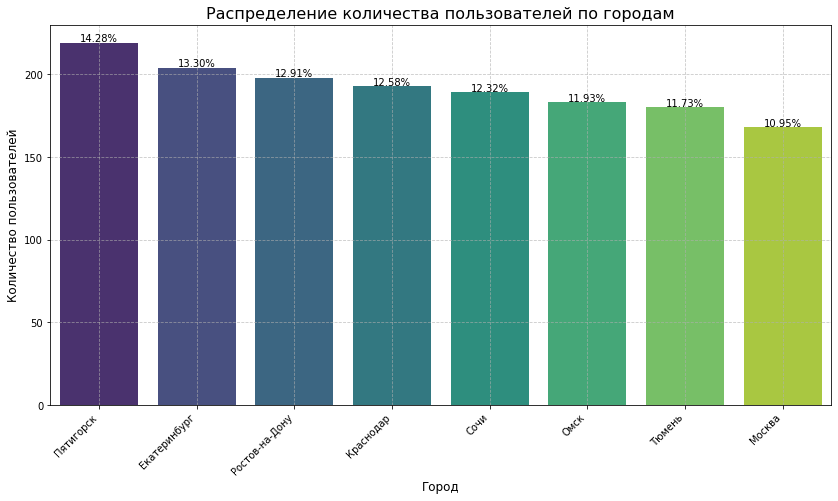

In [25]:
# Настройка размеров графика
plt.figure(figsize=(14, 7))

# Столбчатая диаграмма
ax = sns.barplot(
    data=users_city, 
    x='город', 
    y='количество', 
    palette='viridis'
)

# Добавление долей (%) над столбцами
for i, row in users_city.iterrows():
    plt.text(
        i,                                # X-координата (положение столбца)
        row['количество'] + 0.5,         # Y-координата (высота над столбцом)
        row['доля %'],                   # Текст (доля в %)
        ha='center',                     # Горизонтальное выравнивание
        fontsize=10,                     # Размер текста
        color='black',                   # Цвет текста
    )

# Настройки заголовка и осей
plt.title('Распределение количества пользователей по городам', fontsize=16)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Показ графика
plt.show()


Как видно, сервисом пользуются в городах: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи. 

Наибольшую популярность сервис имеет в городах:
- Пятигорск (14.3% пользователей)
- Екатеринбург (13.3% пользователей).

Наименьшая популярность в Москве (10.9% пользователей).

### Соотношение пользователей с подпиской и без подписки.
Пользователи с подпиской - это тип ultra, пользователи без подписки - это тип free.

In [26]:
# Подсчёт количества пользователей по типу подписки
users_subscription = (
    users_go['subscription_type']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'подписка', 'subscription_type': 'количество'})
)

# подсчет доли в %
users_subscription['доля %'] = (users_subscription['количество'] / users_subscription['количество']\
                                .sum())\
                                .apply(lambda x: f"{x:.2%}")

users_subscription

,подписка,количество,доля %
0,free,835,54.43%
1,ultra,699,45.57%


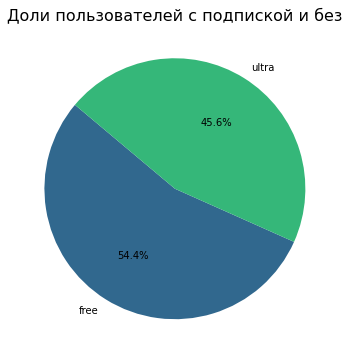

In [27]:
# Круговая диаграмма
plt.figure(figsize=(6, 6))
plt.pie(
    users_subscription['количество'], 
    labels=users_subscription['подписка'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('viridis', len(users_subscription))
)
plt.title('Доли пользователей с подпиской и без', fontsize=16)
plt.show()

Как видно, наибольшее количество пользователей среди сервиса составляют пользователи без подписки (тип free) 54.4%, а пользователи с подпиской (тип ultra) 45.6%. 

Разнизница в соотношении чуть меньше 9%.

### Возраст пользователей.

In [28]:
users_go['age'].describe()

count   1534.000
mean      24.904
std        4.572
min       12.000
25%       22.000
50%       25.000
75%       28.000
max       43.000
Name: age, dtype: float64

1. Минимальный возраст пользователей 12 лет (возможно это нижняя граница возрастного ценза для пользователей сервиса), а максимальный 43 года.
2. Пользователи сервиса - это в большинстве своем молодые люди, т.к. 25% пользователей моложе 22 лет, 75% пользователей моложе 28 лет, а средний возраст составляет примерно 25 лет (средние и медианные значения возрастов примерно равны).
3. Стандартное отклонение (4.57) и интерквартильный размах (28 - 22 = 6) указывают на относительно однородное распределение возрастов вокруг среднего значения.
4. Можно сделать вывод, что сервис направлян на молодую и подростковую аудиторию.

Далее выведу ТОП-15 возрастов по количеству пользователей и проведу анализ на возможные выбросы в данных.

In [29]:
# Подсчёт количества пользователей по возрастам 
users_age = (
    users_go['age']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'возраст', 'age': 'количество'})
)

# подсчет доли в %
users_age['доля %'] = (users_age['количество'] / users_age['количество'].sum())\
    .apply(lambda x: f"{x:.2%}")

users_age

,возраст,количество,доля %
0,25,145,9.45%
1,24,132,8.60%
2,26,131,8.54%
3,23,129,8.41%
4,27,119,7.76%
5,22,119,7.76%
6,28,112,7.30%
7,21,93,6.06%
8,20,71,4.63%
9,30,68,4.43%


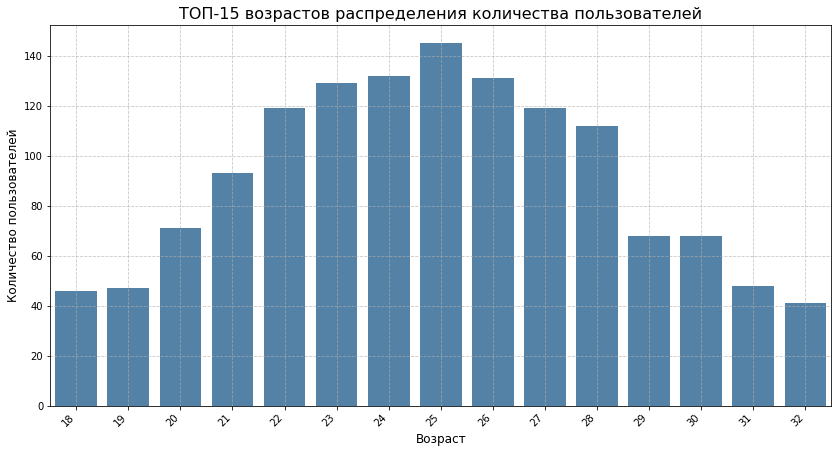

In [30]:
users_age_15 = users_age.head(15)

# Настройка размеров графика
plt.figure(figsize=(14, 7))

# Столбчатая диаграмма
sns.barplot(
    data=users_age_15, 
    x='возраст',
    y='количество', 
    color='steelblue'
)


# Настройки заголовка и осей
plt.title('ТОП-15 возрастов распределения количества пользователей', fontsize=16)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Показ графика
plt.show()


Видно, что график имеет нормальное распределение и подтверждает, что большинство пользователей сервиса - это молодые люди в возрасте от 20 до 28 лет, так же видно, что количество пользователей моложе 20 лет и страше 28 значительно меньше. Наибольшее количество пользователей в возрасте 25 лет.


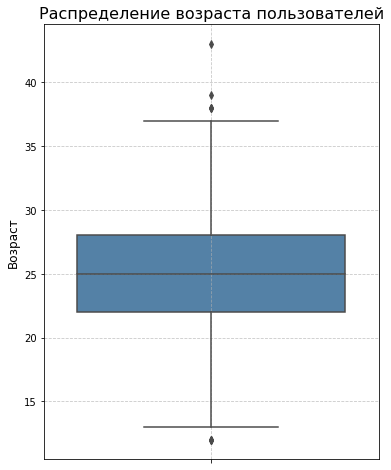

In [31]:
# Настройка размера графика
plt.figure(figsize=(6, 8))

# Построение ящика с усами
sns.boxplot(y=users_go['age'], color="steelblue")

# Настройки заголовка и осей
plt.title('Распределение возраста пользователей', fontsize=16)
plt.ylabel('Возраст', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показ графика
plt.show()


Ящик с усами и сводная таблица распределения пользователей по возрастам подтверждает, что целевая аудитория сервиса - это молодые люди в возрасте старше 15 и моложе 35 лет, т.е. пользователи моложе 15 лет и старше 35 - это единичные случаи.

**Общие выводы:**
1. Минимальный возраст пользователей 12 лет, а максимальный 43 года.
2. Целевая аудитория пользователей - это молодые люди в возрасте от 22 до 28 летю
3. 25% пользователей моложе 22 лет, 75% пользователей моложе 28 лет, 
4. Средний возраст составляет 25 лет (средние (24.9) и медианные (25) значения возрастов примерно равны).
5. Стандартное отклонение (4.5) и интерквартильный размах (28 - 22 = 6) указывают на относительно однородное распределение возрастов вокруг среднего значения.

### Расстояние, которое пользователь преодолел за одну поездку.

In [32]:
rides_go['distance'].describe()

count   18068.000
mean     3070.660
std      1116.831
min         0.856
25%      2543.226
50%      3133.610
75%      3776.223
max      7211.008
Name: distance, dtype: float64

Из статистических данных можно сделать следующие выводы:
1. Минимальная поездка составила менее 1м (0.856 м), что указывает на наличие выбросов в даннх или технической ошибке - пользователь случайно начал поездку и тут жее ее завершил.
2. Максимальное значение расстояния одной поездки 7 км (7211 м) тоже достаточно сомнительно, возможно присутствуют выбросы.
3. Большинство поездок укладываются в диапазон от 2.5 км до 3.7 км.
4. 25% поездок менее 2543 м, а 75% поездок менее 3776 метров.
5. Медианное (50%- 3133м) и средние (3070 м) значения примерно равны, что указывает на относительно симметричное распределение данных
6. Стандартное отклонение 1116 м (1.1 км) указывает, что  распределение расстояний имеет умеренную вариативность и значительное число поездок отклоняется от среднего на ~1.12 км.

Рассмотрю распределение данных на гистограмме и построю ящик с усами для определения наличия выбросов.

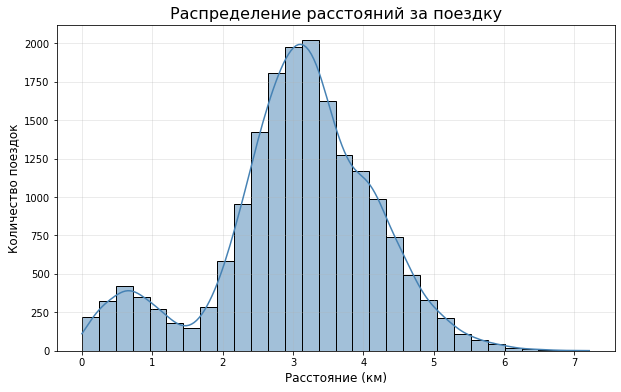

In [33]:
plt.figure(figsize=(10, 6))

sns.histplot(rides_go['distance'] / 1000, bins=30, kde=True, color='steelblue')  # Конвертация в километры
plt.title('Распределение расстояний за поездку', fontsize=16)
plt.xlabel('Расстояние (км)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(alpha=0.3)

plt.show()


- Распределение имеет вид колоколообразной кривой, что указывает на нормальное распределение данных.
- Большинство поездок сконцентрировано около среднего значения, примерно в диапазоне 2–4 км.
- Наибольшее количество поездок приходится на 3 км.
- Есть некоторое количество поездок с большими расстояниями (>5 км), но их доля небольшая.
- В начале распределения есть небольшое число поездок с очень короткими расстояниями. Это может свидетельствовать об ошибках при регистрации данных (например, пользователь начал и сразу завершил поездку) или реальных коротких поездках (например, до соседнего дома).

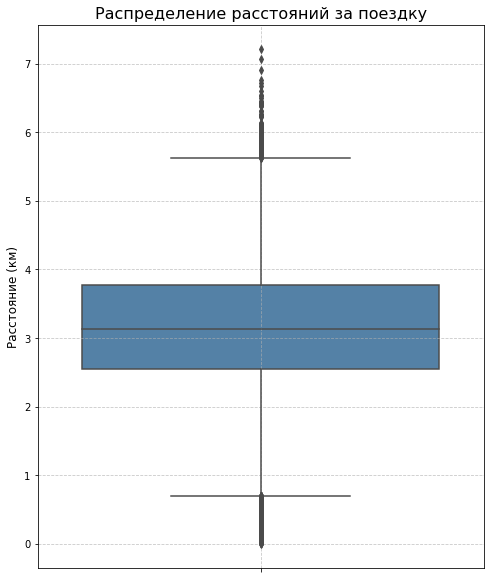

In [34]:
# Настройка размера графика
plt.figure(figsize=(8, 10))

# Построение ящика с усами
sns.boxplot(y=rides_go['distance'] /1000, color="steelblue")

# Настройки заголовка и осей
plt.title('Распределение расстояний за поездку', fontsize=16)
plt.ylabel('Расстояние (км)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показ графика
plt.show()

Из распределения данных видно, что присутствуют выбросы - это поездки менее 1км и более 5 км.

Для более точного определения выбросов построю гистограммы с распределение поездок до 200 метров и более 5 км.

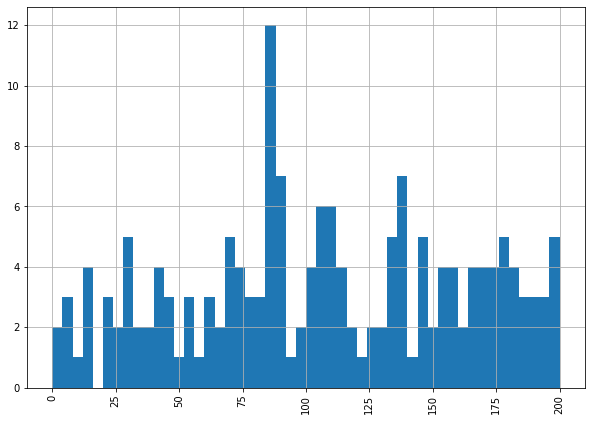

In [35]:
plt.figure(figsize=(10, 7))
rides_go['distance'].hist(bins=50, range=(0,200))
plt.xticks(rotation=90)
plt.show()

In [36]:
display(rides_go.query('distance <= 20.000'))

,user_id,distance,duration,date,month
7841,796,7.097,10.027,2021-11-26,11
8324,835,12.233,4.035,2021-09-19,9
8658,861,6.784,6.016,2021-07-21,7
8906,880,11.284,2.036,2021-03-28,3
9541,925,2.571,3.011,2021-10-19,10
11555,1069,0.856,10.002,2021-01-31,1
11862,1091,15.631,13.045,2021-03-29,3
13690,1223,4.330,4.009,2021-05-22,5
13940,1240,15.001,10.045,2021-08-20,8
15626,1364,15.366,6.058,2021-08-22,8


В распределение поездок до 200 метров видно, что есть выпад в значении 20 метров, т.е. все поездки, которые менее 20 метров - это нетипичные поездки, т.е. выбросы в данных. Таких поездок единицы, существенно они не исказят анализ, но за них начислялась оплата, поэтому удалять их из данных не буду.

Далее рассмотрю подробнее поездки от 5км и более.

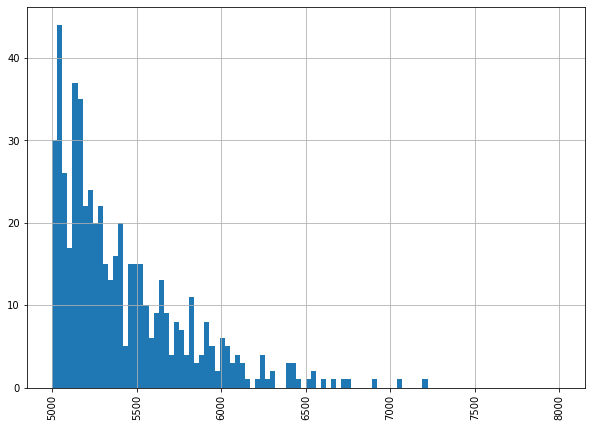

In [37]:
plt.figure(figsize=(10, 7))
rides_go['distance'].hist(bins=100, range=(5000, 8000))
plt.xticks(rotation=90)
plt.show()

In [38]:
display(rides_go.query('distance >= 6500.000'))

,user_id,distance,duration,date,month
10341,981,6671.970,27.297,2021-12-06,12
10915,1022,6535.387,30.009,2021-10-14,10
11319,1052,6503.600,26.008,2021-07-01,7
11385,1057,6601.198,0.500,2021-02-07,2
12086,1108,6538.937,29.649,2021-09-27,9
15580,1361,6908.491,23.817,2021-03-27,3
16309,1411,7211.008,0.500,2021-04-15,4
16484,1422,7066.004,23.619,2021-02-12,2
17171,1471,6760.940,32.044,2021-08-03,8
17242,1477,6724.933,0.500,2021-01-12,1


В распределение поездок более 5 км появляются провалы в значениях 6.2 км, 6.4 км, 6.5. км и т.д., делаю вывод, что поездки более 6.4 км являются нетепичными, но они имеют место быть и из анализа их удалять не буду, т.к. оплата за такие поездки была произведена.

Так же есть несколько поездок более 5 км, но с подозрительно малым временем - менее минуты, их подробнее рассмотрю в анализе продолжительности поездок.

Далее для анализа возьму датафрейм со следующим условием по расстоянию одной поездки: больше 20 м.

Рассмотрю зависимость расстояния поездки от ее продолжительности.

In [39]:
display(rides_go[['distance', 'duration']].corr())

,distance,duration
distance,1.000,0.537
duration,0.537,1.000


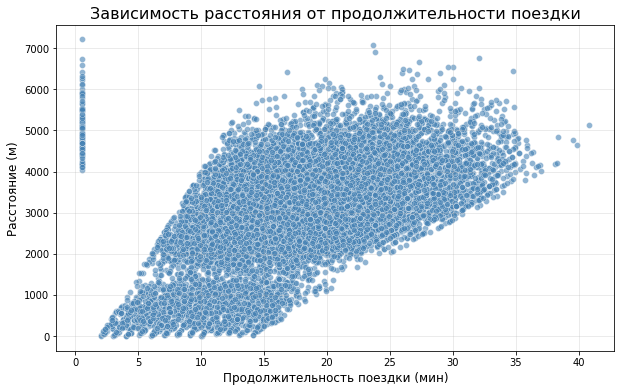

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rides_go, x='duration', y='distance', alpha=0.6, color='steelblue')
plt.title('Зависимость расстояния от продолжительности поездки', fontsize=16)
plt.xlabel('Продолжительность поездки (мин)', fontsize=12)
plt.ylabel('Расстояние (м)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


<AxesSubplot:>

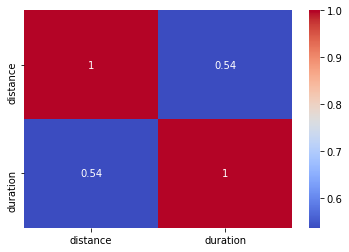

In [41]:
sns.heatmap(
    rides_go[['distance', 'duration']].corr(),
    annot=True, cmap='coolwarm'
)

In [42]:
rides_go['distance'].describe()

count   18068.000
mean     3070.660
std      1116.831
min         0.856
25%      2543.226
50%      3133.610
75%      3776.223
max      7211.008
Name: distance, dtype: float64

**Общий вывод:**
1. В данных обнаружены выбросы - нетипичные поездки: очень короткие менее 20 м и очень длинные более 6400 м.
2. Среднее расстояние одной поездки примерно 3 км (среднее (3070м) и медианное (3134м) значения примерно равны).
3. Большинство поездок укладывается в диапазон от 2.5 до 3.7 км.
4. 25% поездок меньше 2.5 км, а 75% поездок менее 3.7 км.
5. Прослеживается небольшая положительная зависимость расстояния от продолжительности поездки, коэффициент корреляции составляет 0.54.
6. Вероятнее всего поездки на расстоянеие от 0.8м до 2км стоит рассмотреть и проанализировать отдельной категорией, т.к. они нетипичны, но такие поездки имеют место быть. 

### Продолжительность поездок.

In [43]:
rides_go['duration'].describe()

count   18068.000
mean       17.805
std         6.091
min         0.500
25%        13.598
50%        17.678
75%        21.725
max        40.824
Name: duration, dtype: float64

Из статистических данных можно сделать следующие выводы:
1. Минимальное время одной поездки менее 1мин (0.5 мин), что указывает на наличие выбросов в даннх или технической ошибке - пользователь случайно начал поездку и тут жее ее завершил.
2. Максимальное время одной поездки 40.8 мин.
3. Большинство поездок укладываются в временной диапазон от 13 до 21 мин.
4. 25% поездок менее 13 мин, а 75% поездок менее 21.7 мин.
5. Медианное (50%- 17.6 мин) и средние (17.8 мин) значения примерно равны, что указывает на относительно симметричное распределение данных
6. Стандартное отклонение 6.077 мин указывает, что  распределение продолжительности одной сессии имеет умеренную вариативность и значительное число поездок отклоняется от среднего на ~ 6 мин.

Рассмотрю распределение данных на гистограмме и построю ящик с усами для определения наличия выбросов.

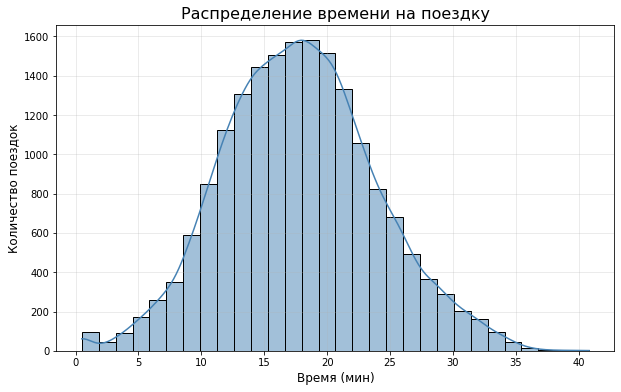

In [44]:
plt.figure(figsize=(10, 6))

sns.histplot(rides_go['duration'], bins=30, kde=True, color='steelblue')
plt.title('Распределение времени на поездку', fontsize=16)
plt.xlabel('Время (мин)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(alpha=0.3)

plt.show()

- Распределение имеет вид колоколообразный, что указывает на нормальное распределение данных.
- Большинство поездок сконцентрировано около среднего значения, примерно в диапазоне 10–25 мин.
- Наибольшее количество поездок приходится на ~18 мин.
- Есть некоторое количество поездок с большей продолжительностью (>35 мин), но их доля небольшая.
- В начале распределения есть небольшое число поездок с очень короткой продолжительностью. Это может свидетельствовать об ошибках при регистрации данных (например, пользователь начал и сразу завершил поездку) или реальных коротких поездках (например, до соседнего дома).

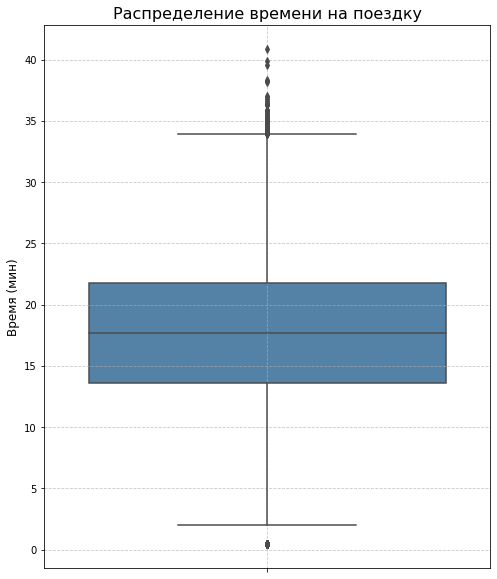

In [45]:
# Настройка размера графика
plt.figure(figsize=(8, 10))

# Построение ящика с усами
sns.boxplot(y=rides_go['duration'], color="steelblue")

# Настройки заголовка и осей
plt.title('Распределение времени на поездку', fontsize=16)
plt.ylabel('Время (мин)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Показ графика
plt.show()

Из распределения данных видно, что присутствуют выбросы - это поездки менее 1 мин и более 35 мин.

Для более точного определения выбросов построю гистограммы с распределение поездок до 10 мин и более 30 мин.

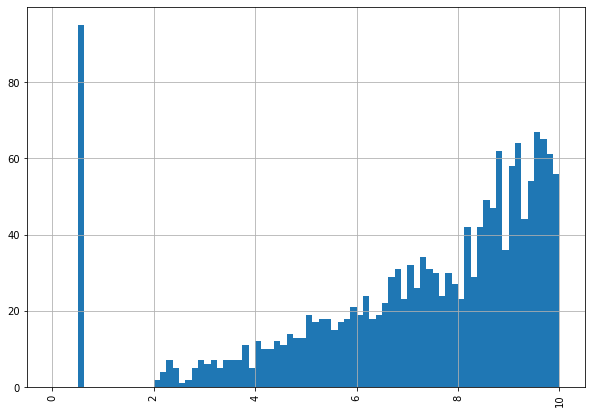

In [46]:
plt.figure(figsize=(10, 7))
rides_go['duration'].hist(bins=80, range=(0, 10.000))
plt.xticks(rotation=90)
plt.show()

Из гистограммы видно, что присутствует некоторое количество поездок с аномально малым временем - менее 2-х минут. Рассмотрю данные поездки более подробно.

In [47]:
display(rides_go.query('duration <= 2.000'))

,user_id,distance,duration,date,month
6531,701,4196.445,0.500,2021-08-31,8
6570,704,4830.824,0.500,2021-10-14,10
6680,712,4684.004,0.500,2021-03-04,3
6695,713,5215.643,0.500,2021-02-25,2
6768,718,5197.437,0.500,2021-02-11,2
6860,724,6225.520,0.500,2021-12-16,12
6883,726,4452.492,0.500,2021-03-01,3
7018,735,4406.955,0.500,2021-04-13,4
7160,745,5286.168,0.500,2021-08-17,8
7364,760,4881.392,0.500,2021-08-29,8


В данных присутствуют поездки с аномально малым временем - менее одной минуты (0.5 мин), а расстояние для таких поездок более 4 км, вероятниее вего произошел какой-то технический сбой и время сессии данных поездок считалось некорретно, удалю такие поездки из анализа, что бы они не искажили данные, тем более доля таких поездок мала.

Рассмотрю поездки более 30 мин.

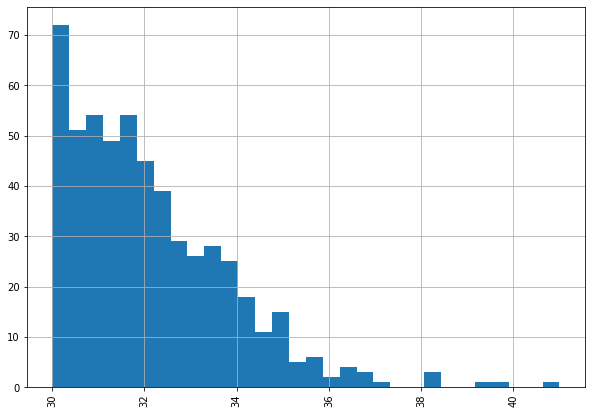

In [48]:
plt.figure(figsize=(10, 7))
rides_go['duration'].hist(bins=30, range=(30.000, 41.000))
plt.xticks(rotation=90)
plt.show()

In [49]:
display(rides_go.query('duration >= 38.000'))

,user_id,distance,duration,date,month
143,15,4187.621,38.126,2021-01-13,1
1998,216,4831.340,38.353,2021-05-11,5
2623,278,4754.434,39.527,2021-12-02,12
4215,454,5137.327,40.824,2021-12-27,12
4709,507,4645.643,39.874,2021-01-15,1
6453,694,4210.871,38.265,2021-03-11,3


Рассмотрев гистограмму распределения поездок время которых составило более 30 минут, видны выпады в данных начиная с 37-ой минуты, а изучив такие поездки (дольше 38 минут) пришла к выводу, что они являются выбросами, т.к. пройденное растояние от 4 до 5 км мало для этой продолжительности, вероятнее всего пользователь забыл нажать «Завершить поездку» по окончанию маршрута.
Доля таких поездок несущественна (менее 1%), удалять их из анализа не буду, т.к. за них начислялась оплата.

Далее для анализа возьму данные, где продолжительность сессии будет составлять более 1 минуты.

In [50]:
# фильтрация датафрейма по продолжительности сессии
# больше 1 мин и меньше 37 мин
rides_go = rides_go.query('duration >= 1.000')

# проверка фильтрации
rides_go['duration'].describe()

count   17973.000
mean       17.896
std         5.975
min         2.036
25%        13.670
50%        17.714
75%        21.747
max        40.824
Name: duration, dtype: float64

**Общий вывод:**
1. Минимальная поездка составила 2 минуты, а максимальная 40 минут.
2. Средняя продолжительность одной поездки 17 мин (среднее (17.8) и медианное (17.7) значения примерно равны).
3. Большинство поездок укладывается в диапазон от 13 до 22 мин.
4. 25% поездок меньше 13.6 мин, а 75% поездок менее 21.7 мин.
5. В данных обнаружены выбросы - нетипичные поездки: очень короткие менее 1 мин (их удалила из анализа) и нетипично длинные (если брать во вниманиее, что присутствует зависимость расстояния от времени) более 38 мин.

In [51]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


**Общая доля удаленных выбросов в данных составила менее 1 %.**

### Выводы исследовательского анализа.
В ходе исследовательского анализа были выполнены следующие работы:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

**Ключевые выводы исследовательского анализа**

1. ***Частота встречаемости городов:***
Сервисом пользуются в городах: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи. 

Наибольшую популярность сервис имеет в городах:
- Пятигорск (14.3% пользователей)
- Екатеринбург (13.3% пользователей).

Наименьшая популярность в Москве (10.9% пользователей).

2. ***Соотношение пользователей с подпиской и без подписки:***
- пользователей без подписки (тип free) 54.4%,
- пользователей с подпиской (тип ultra) 45.6%. 

Разнизница в соотношении чуть меньше 9%.

3. ***Возраст пользователей:***
- Минимальный возраст пользователей 12 лет, а максимальный 43 года.
- Целевая аудитория пользователей - это молодые люди в возрасте от 22 до 28 летю
- 25% пользователей моложе 22 лет, 75% пользователей моложе 28 лет, 
- Средний возраст составляет 25 лет (средние (24.9) и медианные (25) значения возрастов примерно равны).
- Стандартное отклонение (4.5) и интерквартильный размах (28 - 22 = 6) указывают на относительно однородное распределение возрастов вокруг среднего значения.

4. ***Расстояние за одну поездку:***
- В данных обнаружены выбросы - нетипичные поездки: очень короткие менее 20 м и очень длинные более 6400 м.
- Среднее расстояние одной поездки примерно 3 км (среднее (3070м) и медианное (3134м) значения примерно равны).
- Большинство поездок укладывается в диапазон от 2.5 до 3.7 км.
- 25% поездок меньше 2.5 км, а 75% поездок менее 3.7 км.
- Прослеживается небольшая положительная зависимость расстояния от продолжительности поездки, коэффициент корреляции составляет 0.54.
- Вероятнее всего поездки на расстоянеие от 0.8м до 2км стоит рассмотреть и проанализировать отдельной категорией, т.к. они нетипичны и их много, но такие поездки имеют место быть. 

5. ***Продолжительность поездок:***
- Минимальная поездка составила 2 минуты, а максимальная 40 минут.
- Средняя продолжительность одной поездки 17 мин (среднее (17.8) и медианное (17.7) значения примерно равны).
- Большинство поездок укладывается в диапазон от 13 до 22 мин.
- 25% поездок меньше 13.6 мин, а 75% поездок менее 21.7 мин.
- В данных обнаружены выбросы - нетипичные поездки: очень короткие менее 1 мин (их удалила*) и нетипично длинные (если брать во вниманиее, что присутствует зависимость расстояния от времени) более 38 мин.

*Доля удаленных данных (выбросов) в датафрейме с Поездками менее 1%.

## Объединение данных.
1. Объедините данные о пользователях, поездках и подписках в один датафрейм методом merge().
2. Создайте ещё два датафрейма из датафрейма, созданного на этапе 1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.
3. Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

### Объединение данных в один датафрейм.

In [52]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [53]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


In [54]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Типы данных для всех полей корретные и не требуют изменнений перед объединением.

Логика объединения таблиц о Пользователях, Поездках и Подписках:
1. Все таблицы объединяем методом типом outer, т.е. полное объединение данных.
2. Сначала объединяю user_id и subscriptions_go по полю 'subscription_type'.
3. Потом к получившемуся объединению присоединяю rides_go по полю 'user_id.

In [55]:
#df = pd.merge(users_go, subscriptions_go, on='subscription_type', how='left')
#data = pd.merge(df, rides_go, on='user_id', how='left')

df = pd.merge(users_go, subscriptions_go, on='subscription_type', how='outer')
data = pd.merge(df, rides_go, on='user_id', how='outer')

# проверка объединения
# Количество строк в исходных таблицах
display('users_go кол-во строк и столбцов:', users_go.shape)
display('subscriptions_go кол-во строк и столбцов:', subscriptions_go.shape)
display('rides_go кол-во строк и столбцов:', rides_go.shape)

# Количество строк в объединённой таблице
display('кол-во строк и столбцов в объединение df', df.shape)
display('кол-во строк и столбцов в объединение data:', data.shape)


'users_go кол-во строк и столбцов:'

(1534, 5)

'subscriptions_go кол-во строк и столбцов:'

(2, 4)

'rides_go кол-во строк и столбцов:'

(17973, 5)

'кол-во строк и столбцов в объединение df'

(1534, 8)

'кол-во строк и столбцов в объединение data:'

(17973, 12)

In [56]:
# информация о количестве пропусков (в %) в датафрейме users_go
display((data.isna().mean() * 100).sort_values(ascending=False))

user_id             0.000
name                0.000
age                 0.000
city                0.000
subscription_type   0.000
minute_price        0.000
start_ride_price    0.000
subscription_fee    0.000
distance            0.000
duration            0.000
date                0.000
month               0.000
dtype: float64

In [57]:
data.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919,25.600,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592,15.817,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.160,6.232,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783,18.511,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687,26.266,2021-08-28,8


Объединение таблиц в один датафрейм прошло корректно: все строки и столбцы попали в общую таблицу, пропусков в данных нет.

### Датафреймы с пользователями без подписки и с подпиской.
Создам два датафрейма с пользователями без подписки user_free и с подпиской user_ultra.

Создание датафреймов выполню, путем разделения объединенного датафрейма data по типу подписки.

In [58]:
user_free = data[data['subscription_type'] == 'free']
user_ultra = data[data['subscription_type'] == 'ultra']

display('Пользователи без подписки:', user_free.shape)
display('Пользователи с подпиской', user_ultra.shape)

'Пользователи без подписки:'

(11473, 12)

'Пользователи с подпиской'

(6500, 12)

Разделение датафрейма на 2 по типу подписки прошло успешно. Видно, что доля пользователей без подписки больше.

### Визуализация информации о расстоянии и времени поездок.

#### Пользователи без подписки.

In [59]:
user_free.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.691,14.944,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.933,16.235,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434,20.017,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911,9.783,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379,17.428,2021-02-14,2


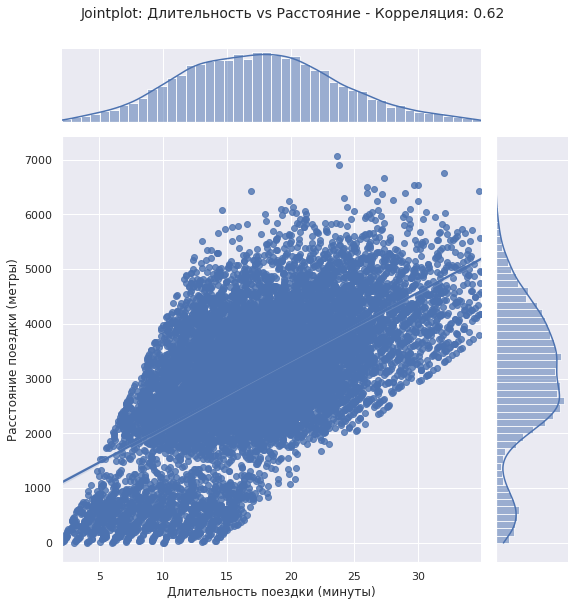

In [60]:
# Стиль графика
sns.set(style="darkgrid")

# Параметры размера графика
plot_width = 8
plot_height = 8

# Подсчёт корреляции
correlation = user_free['duration'].corr(user_free['distance'])

# Построение jointplot с регрессией
ax = sns.jointplot(
    x='duration', 
    y='distance', 
    data=user_free, 
    kind='reg',  # Регрессия
    height=plot_height  # Размер графика
)

# Устанавливаем метки осей
ax.set_axis_labels('Длительность поездки (минуты)', 'Расстояние поездки (метры)', fontsize=12)

# Заголовок с добавлением значения корреляции
plt.suptitle(f'Jointplot: Длительность vs Расстояние - Корреляция: {correlation:.2f}', y=1.05, fontsize=14)

# Отображение графика
plt.show()


1. Видно, что есть прямая положительная зависимость длительности поездок от расстояния, коэффициент корреляции 0.62.
2. Большинство поездок сконцентрировано в диапазонах: длительностью 5–25 минут и расстоянием 1500–5000 метров.
Есть поездки с короткой длительностью (менее 10 минут) при сравнительно большом расстоянии (3000 м).
Аналогично, присутствуют поездки с длительностью свыше 20 минут при небольшом расстоянии (менее 2000 м), вероятнее всего - это поездки с долгими остановками.
3. Распределение:
- Длительность поездки: распределение близко к нормальному, с пиком около 15–20 минут.
- Расстояние: распределение имеет ассиметричный вид, кривой, с пиками около 500м и 3000м.

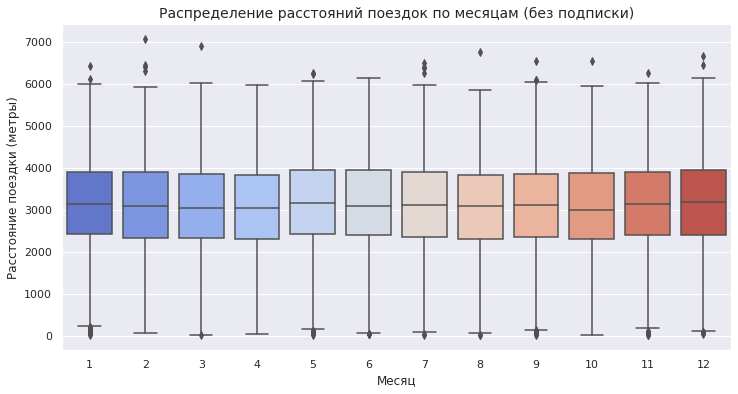

In [61]:
# Boxplot: Сравнение расстояния по месяцам
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_free, x='month', y='distance', palette='coolwarm')
plt.title('Распределение расстояний поездок по месяцам (без подписки)', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Расстояние поездки (метры)', fontsize=12)
plt.show()

Из распределения суммарного расстояния поездок по месяцам можно сделать следующие выводы:
1. Во всех месяцах медианное значение (центральная линия в ящике) примерно одинаковое — около 3000 метров. Это говорит о стабильности средней дистанции поездок в течение года.
2. Верхняя и нижняя границы ящика показывают диапазон расстояний между 25% и 75% пользователей. Межквартильный размах примерно одинаковый для всех месяцев, что указывает на схожесть в поведении большинства пользователей.
3. Выбросы (отмечены точками за пределами "усов") наблюдаются во всех месяцах. Это свидетельствует о наличии пользователей, чьи поездки значительно меньше или превышают обычные дистанции.
4. Нет ярко выраженных изменений в распределении расстояния поездок по месяцам. Распределение остаётся стабильным, без резких изменений как в медиане, так и в размаху. Это может свидетельствовать о том, что поведение пользователей не зависит от времени года.

#### Пользователи c подпиской.

In [62]:
user_ultra.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919,25.600,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592,15.817,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.160,6.232,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783,18.511,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687,26.266,2021-08-28,8


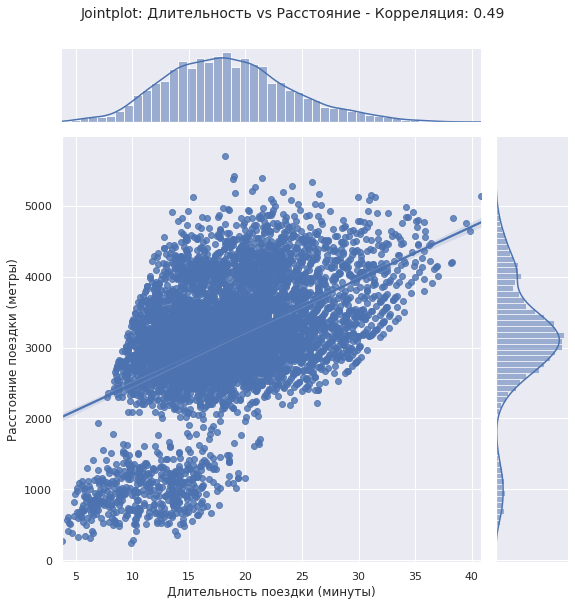

In [63]:
# Стиль графика
sns.set(style="darkgrid")

# Параметры размера графика
plot_width = 8
plot_height = 8

# Подсчёт корреляции
correlation = user_ultra['duration'].corr(user_ultra['distance'])

# Построение jointplot с регрессией
ax = sns.jointplot(
    x='duration', 
    y='distance', 
    data=user_ultra, 
    kind='reg',  # Регрессия
    height=plot_height  # Размер графика
)

# Устанавливаем метки осей
ax.set_axis_labels('Длительность поездки (минуты)', 'Расстояние поездки (метры)', fontsize=12)

# Заголовок с добавлением значения корреляции
plt.suptitle(f'Jointplot: Длительность vs Расстояние - Корреляция: {correlation:.2f}', y=1.05, fontsize=14)

# Отображение графика
plt.show()


1. Видно, что есть прямая положительная зависимость длительности поездок от расстояния, но она гораздо меньше, чем у пользователей без подписки, коэффициент корреляции 0.49.
2. Большинство поездок сконцентрировано в диапазонах: длительностью 10–25 минут и расстоянием 2200–3700 метров.
Есть поездки с короткой длительностью (менее 10 минут) при сравнительно большом расстоянии (2000 м).
Аналогично, присутствуют поездки с длительностью свыше 20 минут при небольшом расстоянии (менее 2000 м).
3. Распределение:
- Длительность поездки: распределение близко к нормальному, с пиком около 17 минут.
- Расстояние: распределение имеет ассиметричный вид, кривой, с пиками около 1000м,  3300м и 4000м.

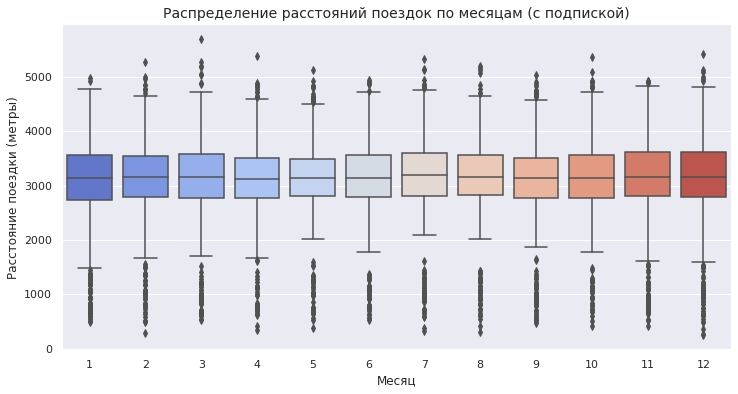

In [64]:
# Boxplot: Сравнение расстояния по месяцам
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_ultra, x='month', y='distance', palette='coolwarm')
plt.title('Распределение расстояний поездок по месяцам (с подпиской)', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Расстояние поездки (метры)', fontsize=12)
plt.show()

Из распределения суммарного расстояния поездок по месяцам можно сделать следующие выводы:
1. Во всех месяцах медианное значение (центральная линия в ящике) примерно одинаковое — около 3300 метров. Это говорит о стабильности средней дистанции поездок в течение года.
2. Верхняя и нижняя границы ящика показывают диапазон расстояний между 25% и 75% пользователей. Межквартильный размах примерно одинаковый для всех месяцев, что указывает на схожесть в поведении большинства пользователей, за исключением теплых месяцев с мая по сентябрь.
3. Выбросы (отмечены точками за пределами "усов") наблюдаются во всех месяцах. Это свидетельствует о наличии пользователей, чьи поездки значительно меньше или превышают обычные дистанции.
4. Наблюдается изменение в расстоянии поезок в теплые месяцы с мая по сентябрь - это может свидетельствовать о сезонности поведения пользователей, но медианное значение остается примерно одинаковым для всех месяцев. 

### Общие выводы.
1. **Логика объединения таблиц о Пользователях, Поездках и Подписках:**
- Все таблицы объединяем методом типом outer, т.е. полное объединение данных.
- Сначала объединяю user_id и subscriptions_go по полю 'subscription_type'.
- Потом к получившемуся объединению присоединяю rides_go по полю 'user_id.
2. **Разделение датафрема на пользователей без подписки и с подпиской:**
Создание датафреймов выполнено, путем разделения объединенного датафрейма data по типу подписки (free, ultra)
- пользователи без подписки user_free,
- пользователи с подпиской user_ultra.
- доля пользователей без подписки больше.
3. **Визуализация данных:**

*Пользователи без подписки*
1. Зависимость и распределение длитильности и расстояния
-  есть прямая положительная зависимость длительности поездок от расстояния, коэффициент корреляции 0.62.
- большинство поездок сконцентрировано в диапазонах: длительностью 5–25 минут и расстоянием 1500–5000 метров.
Есть поездки с короткой длительностью (менее 10 минут) при сравнительно большом расстоянии (3000 м).
Аналогично, присутствуют поездки с длительностью свыше 20 минут при небольшом расстоянии (менее 2000 м), вероятнее всего - это поездки с долгими остановками.
- Распределение: длительность поездки: распределение близко к нормальному, с пиком около 15–20 минут. Расстояние: распределение имеет ассиметричный вид, кривой, с пиками около 500м и 3000м.
2. Боксплот
- Во всех месяцах медианное значение (центральная линия в ящике) примерно одинаковое — около 3000 метров. Это говорит о стабильности средней дистанции поездок в течение года.
- Верхняя и нижняя границы ящика показывают диапазон расстояний между 25% и 75% пользователей. Межквартильный размах примерно одинаковый для всех месяцев, что указывает на схожесть в поведении большинства пользователей.
- Выбросы (отмечены точками за пределами "усов") наблюдаются во всех месяцах. Это свидетельствует о наличии пользователей, чьи поездки значительно меньше или превышают обычные дистанции.
- Нет ярко выраженных изменений в распределении расстояния поездок по месяцам. Распределение остаётся стабильным, без резких изменений как в медиане, так и в размаху. Это может свидетельствовать о том, что поведение пользователей не зависит от времени года.

*Пользователи с подпиской*
1. Зависимость и распределение длительности и расстояния
- есть прямая положительная зависимость длительности поездок от расстояния, но она гораздо меньше, чем у пользователей без подписки, коэффициент корреляции 0.49.
- Большинство поездок сконцентрировано в диапазонах: длительностью 10–25 минут и расстоянием 2200–3700 метров.
Есть поездки с короткой длительностью (менее 10 минут) при сравнительно большом расстоянии (2000 м).
Аналогично, присутствуют поездки с длительностью свыше 20 минут при небольшом расстоянии (менее 2000 м).
- Распределение: длительность поездки: распределение близко к нормальному, с пиком около 17 минут. Расстояние: распределение имеет ассиметричный вид, кривой, с пиками около 1000м,  3300м и 4000м.
2. Боксплот
- Во всех месяцах медианное значение (центральная линия в ящике) примерно одинаковое — около 3300 метров. Это говорит о стабильности средней дистанции поездок в течение года.
- Верхняя и нижняя границы ящика показывают диапазон расстояний между 25% и 75% пользователей. Межквартильный размах примерно одинаковый для всех месяцев, что указывает на схожесть в поведении большинства пользователей, за исключением теплых месяцев с мая по сентябрь.
- Выбросы (отмечены точками за пределами "усов") наблюдаются во всех месяцах. Это свидетельствует о наличии пользователей, чьи поездки значительно меньше или превышают обычные дистанции.
- Наблюдается изменение в расстоянии поезок в теплые месяцы с мая по сентябрь - это может свидетельствовать о сезонности поведения пользователей, но медианное значение остается примерно одинаковым для всех месяцев.

## Подсчёт выручки.
1. Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными data: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
2. В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь.

### Агрегирование данных в датафрейм.

In [65]:
# Округляем продолжительность каждой поездки вверх
data['duration'] = np.ceil(data['duration'])

# Группировка по пользователю и месяцу
aggregated_data = (
    data.groupby(['user_id', 'month'])
    .agg(
        total_distance=('distance', 'sum'),      # Суммарное расстояние
        total_rides=('date', 'count'),          # Количество поездок
        total_duration=('duration', 'sum'),      # Суммарное время поездок
        subscription_type=('subscription_type', 'first'),  # Тип подписки
        minute_price=('minute_price', 'first'), # Стоимость минуты
        start_ride_price=('start_ride_price', 'first'), # Стоимость старта
        subscription_fee=('subscription_fee', 'first')) # Стоимость подписки
    .reset_index()
        
)

# Просмотр итогового датафрейма
aggregated_data.head()


,user_id,month,total_distance,total_rides,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511,2,42.000,ultra,6,0,199
1,1,4,754.160,1,7.000,ultra,6,0,199
2,1,8,6723.471,2,46.000,ultra,6,0,199
3,1,10,5809.911,2,32.000,ultra,6,0,199
4,1,11,7003.499,3,56.000,ultra,6,0,199


In [66]:
# информация о количестве пропусков (в %) в датафрейме aggregated_data
display((aggregated_data.isna().mean() * 100).sort_values(ascending=False))

user_id             0.000
month               0.000
total_distance      0.000
total_rides         0.000
total_duration      0.000
subscription_type   0.000
minute_price        0.000
start_ride_price    0.000
subscription_fee    0.000
dtype: float64

В сводной таблице aggregated_data пропусков в данных нет, можно приступать к расчетом нового столбца с данными о помесячной выручке.

### Помесячная выручка от каждого пользователя.
Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [67]:
# добаление поля с выручкой
aggregated_data['monthly_revenue'] = (
    (aggregated_data['start_ride_price']*aggregated_data['total_rides'])+
    (aggregated_data['minute_price']*aggregated_data['total_duration'])+
     aggregated_data['subscription_fee']
)

# итоговый датафрейм, вывожу только требуемые поля
aggregated_data_total = aggregated_data[['user_id', 
                                         'month',                                         
                                         'total_distance', 
                                         'total_rides', 
                                         'total_duration',
                                         'subscription_type',
                                         'monthly_revenue']]
aggregated_data_total.head()

,user_id,month,total_distance,total_rides,total_duration,subscription_type,monthly_revenue
0,1,1,7027.511,2,42.000,ultra,451.000
1,1,4,754.160,1,7.000,ultra,241.000
2,1,8,6723.471,2,46.000,ultra,475.000
3,1,10,5809.911,2,32.000,ultra,391.000
4,1,11,7003.499,3,56.000,ultra,535.000


### Выводы:
На этом шаге был создан новый датафрейм aggregated_data_total с даными:
- id пользователя user_id
- номер месяца поездки month
- сумарное расстояние total_distance
- количество поездок total_rides
- суммарная продолжительность поездок total_duration
- тип подписки пользователя subscription_type
- помесячная выручка каждого пользователя monthly_revenue


## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

**Задам нулевую и альтернативную гипотезы:**
- *H_0* - средняя продолжительность поездки пользователей с подпиской и без подписки равны (user_ultra['duration'] = user_free['duration']).
- *H_1* - средняя продолжительность поездки пользователей c подпиской больше, чем у пользователей без подписки (user_ultra['duration'] > user_free['duration']).

**Уровень статистической значимости 5%:**
- alpha=0.05

In [68]:
print('Среднее время на поездку у пользователей с подпиской:', user_ultra['duration'].mean())
print('Среднее время на поездку у пользователей без подписки:', user_free['duration'].mean())

alpha=0.05

results = st.ttest_ind(user_ultra['duration'], user_free['duration'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее время на поездку у пользователей с подпиской: 18.54198516280583
Среднее время на поездку у пользователей без подписки: 17.530771268800226
p-значение: 1.6162210195311063e-29
Отвергаем нулевую гипотезу


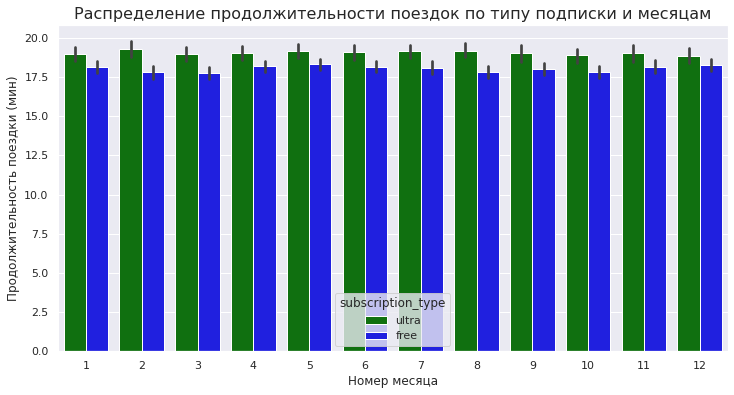

In [69]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = data,
            palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по типу подписки и месяцам', fontsize=16)
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездки (мин)');

**Вывод:**
Отвергаем нулевую гипотезу H_0 - средняя продолжительность поездки пользователей с подпиской и без подписки равны. Пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки, значит пользователи с подпиской выгоднее для бизнеса.

### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

**Задам нулевую и альтернативную гипотезы:**
- *H_0* - среднее расстояние поездки пользователей с подпиской равно 3130м (user_ultra['distance'] = 3130).
- *H_1* - среднее расстояние поездки пользователей с подпиской больше 3130м (user_ultra['duration'] > 3130).

**Уровень статистической значимости 5%:**
- alpha=0.05

In [70]:
avg_ultra_distance = user_ultra['distance'] 
print('Среднее расстояние поездки с подпиской:', user_ultra['distance'].mean())
avg_distance = 3130.0
alpha=0.05

results = st.ttest_1samp(avg_ultra_distance, avg_distance, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее расстояние поездки с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод:** 
Не отвергаем нулевую гипотезу. Гипотеза о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше оптимально 3130м не верна, т.е. пользователи с подпиской в среднем проезжают примерно равное оптимальному по износу самокатов расстояние (3115м).

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Задам нулевую и альтернативную гипотезы:**
- *H_0* - помесячная выручка от пользователей с подпиской (ultra) равна помесячной выручке от пользователей без подписки (free).
- *H_1* - помесячная выручка от пользователей с подпиской (ultra) выше помесячной выручке от пользователей без подписки (free).

**Уровень статистической значимости 5%:**
- alpha=0.05

In [71]:
ultra_monthly_revenue = aggregated_data_total.loc[aggregated_data_total.subscription_type == 'ultra', 'monthly_revenue']
free_monthly_revenue = aggregated_data_total.loc[aggregated_data_total.subscription_type == 'free', 'monthly_revenue']

print('Средняя выручка с подпиской:', ultra_monthly_revenue.mean())
print('Средняя выручка без подписки:', free_monthly_revenue.mean())

alpha=0.05

results = st.ttest_ind(ultra_monthly_revenue, free_monthly_revenue, equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя выручка с подпиской: 362.7921906022502
Средняя выручка без подписки: 329.3326437121324
p-значение: 2.4970242872858465e-38
Отвергаем нулевую гипотезу


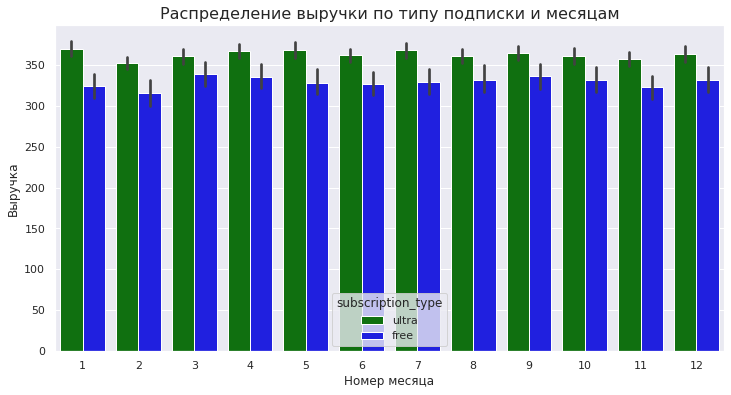

In [72]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'month',
            y = 'monthly_revenue',
            hue = "subscription_type",
            data = aggregated_data_total,
            palette = ['green', 'blue'])
ax.set_title('Распределение выручки по типу подписки и месяцам', fontsize=16)
ax.set(xlabel='Номер месяца', ylabel='Выручка');

**Вывод:**
Отвергаем нулевую гипотезу: H_0 - помесячная выручка от пользователей с подпиской (ultra) равна помесячной выручке от пользователей без подписки (free). Гипотеза о том, что средняя помесячная выручка от пользователей с подпиской, выше чем от пользователей без подписки верна.

### Такая ситуация: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H_0 : μ1 = μ2

H_1 : μ1 != μ2

где μ1 и μ2 - средние значения количества обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

## Итоговый вывод и рекомендации для бизнеса.

Анализ показал, что сервис проката самокатов имеет четко выраженную целевую аудиторию и стабильное поведение пользователей, что важно для прогнозирования доходов и управления ресурсами.

**Выводы**
1.	*Города:* Популярность сервиса зависит от региона. Наибольшую долю пользователей имеют Пятигорск и Екатеринбург, а Москва демонстрирует относительно низкий уровень участия. Это может быть связано с конкуренцией, инфраструктурой или характеристиками аудитории.
2.	*Подписки:* Пользователи с подпиской (тип ultra) более ценны для бизнеса, поскольку они тратят больше времени на поездку и приносят большую помесячную выручку. Однако, доля пользователей без подписки остается значительной, что открывает возможности для конверсии.
3.	*Возраст:* Основная аудитория — молодые люди от 22 до 28 лет. Это важная информация для таргетированной рекламы и разработки дополнительных продуктов.
4.	*Поездки:* Средние показатели продолжительности (17 минут) и расстояния (3 км) стабильны, что упрощает планирование обслуживания самокатов. Однако присутствие выбросов и нестандартных поездок требует анализа для выявления причин.
5.	*Сезонность:* Поведение пользователей с подпиской в теплые месяцы меняется, что может быть связано с увеличением активности. 
6.	*Гипотезы:*
- Пользователи с подпиской выгоднее для бизнеса, так как приносят больше дохода.
- Среднее расстояние поездок соответствует оптимальному для износа самокатов, что подтверждает устойчивость модели использования.

**Рекомендации для бизнеса:**
1.	*Развитие в регионах:*
- Увеличить присутствие в городах с высоким уровнем участия (Пятигорск, Екатеринбург) через локальные кампании и улучшение сервиса.
- Провести анализ причин низкой популярности в Москве и скорректировать стратегию продвижения.
2.	*Увеличение конверсии:*
- Стимулировать переход пользователей без подписки на подписки через бонусы, скидки и персонализированные предложения.
- Разработать промежуточные уровни подписки с более низкой стоимостью, чтобы привлечь пользователей free-сегмента.
3.	*Оптимизация поездок:*
- Проанализировать и классифицировать выбросы (очень короткие или длинные поездки), чтобы понять их причину (например, технические сбои, неправильное использование).
- Рассмотреть введение динамического ценообразования для коротких поездок или поездок с остановками.
4.	*Сезонные кампании:* Учитывать увеличение активности в теплые месяцы и планировать дополнительные маркетинговые акции и техническое обслуживание самокатов.
5.	*Улучшение пользовательского опыта:*
- Создать образовательный контент для пользователей, объясняющий преимущества подписок.
- Разработать новые функции в приложении (например, маршруты для самокатов, аналитика поездок).
6.	*Долгосрочная стратегия:*
- Мониторить возрастные группы и адаптировать стратегию, если поведение целевой аудитории изменится.
- Постоянно оценивать окупаемость пользователей с подпиской и без неё, чтобы выявлять возможности для дальнейшего роста.
